## :) Step 1: Setup & Web Scraping Naukri job data

### 1.1 Import Libraries

In [91]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import random
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline 
from wordcloud import WordCloud
from IPython.display import Markdown, display

### 1.2 Create a function and fetch 100 pages of job information

In [4]:
def scrape_naukri_jobs(start_page=1):
    # 1. Setup Chrome Options (Headless mode avoids opening a window)
    options = Options()
    # options.add_argument("--headless") 
    options.add_argument("--disable-notifications")
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36")

    # 2. Initialize Driver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    all_jobs = []
    page = start_page
    
    try:
        while True:
            # Construct the URL (Naukri uses a specific URL pattern)
            url = f"https://www.naukri.com/data-analyst-data-scientist-data-engineer-jobs-in-india-{page}"
            driver.get(url)
            
            try:
                wait = WebDriverWait(driver, 10)
                wait.until(EC.presence_of_element_located((By.CLASS_NAME, "srp-jobtuple-wrapper")))
            except:
                print("No job container found. Stopping...")
                break
                
            job_cards = driver.find_elements(By.CLASS_NAME, "srp-jobtuple-wrapper")
            # AUTO STOP CONDITION
            if page == 100:
                print("100 pages Complete!")
                break
                    
            for job in job_cards:
                try:
                    title = job.find_element(By.CLASS_NAME, "title").text
                    company = job.find_element(By.CLASS_NAME, "comp-name").text
                    experience = job.find_element(By.CLASS_NAME, "expwdth").text
                    location = job.find_element(By.CLASS_NAME, "locWdth").text
                    skill_elements = job.find_elements(By.CSS_SELECTOR, "ul.tags-gt li.tag-li")
                    skills = ", ".join([s.text for s in skill_elements])
                    job_post = job.find_element(By.CLASS_NAME, "job-post-day").text
                    rating = job.find_element(By.CLASS_NAME, "main-2").text
    
                    all_jobs.append({
                        "Job_title":title,
                        "Company":company, 
                        "Location":location, 
                        "Experience":experience, 
                        "Key_skills":skills, 
                        "Job_post":job_post, 
                        "Rating":rating
                    })
                except Exception as e:
                    continue # Skip cards that don't match the format
            page += 1
            time.sleep(random.uniform(2, 4))  # anti-blocking delay        

    except Exception as e:
        print(f"Error: {e}")
    finally:
        driver.quit()
        
    return all_jobs


In [5]:
# Run the function
jobs = scrape_naukri_jobs(1)
print(f"\n🎯 Total jobs scraped: {len(jobs)}")

100 pages Complete!

🎯 Total jobs scraped: 1543


### 1.3 Create a dataframe with jobs information

In [ ]:
df = pd.DataFrame(jobs)
# Create CSV file 
df.to_csv("naukri_jobs_dataset1.csv", index=False)

In [2]:
df=pd.read_csv('naukri_jobs_dataset1.csv')

In [3]:
df.sample(7)

,Job_title,Company,Location,Experience,Key_skills,Job_post,Rating
1328,Data Engineer,Info Services,Hybrid - Hyderabad,5-10 Yrs,"Data Bricks, Airflow, Pyspark, Snowflake, Spar...",3+ weeks ago,4.0
1020,Data Engineer,Pepsico,Hybrid - Hyderabad,5-7 Yrs,"Pyspark, Data Engineering, SQL, Python, Azure ...",1 week ago,4.1
1461,Data Engineer,Amazon,Bengaluru,3-8 Yrs,"Computer science, Data management, Data modeli...",3+ weeks ago,3.9
1401,Data Engineer,Team Computers,Mumbai,3-4 Yrs,"hive, python, modeling, oracle, big data techn...",3+ weeks ago,3.6
383,Big Data developer,Diverse Lynx,Bengaluru,4-7 Yrs,"big data administration, hive, cloudera, pytho...",3+ weeks ago,3.5
44,Data Engineer,Accenture,Gurugram,3-8 Yrs,"data engineer, data analytics, oracle, data pi...",6 days ago,3.7
621,Data Engineer,Accenture,Pune,3-8 Yrs,"data engineer, etl tools, data management, dat...",4 days ago,3.7


### 1.4 Information of all Columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Job_title   1543 non-null   object 
 1   Company     1543 non-null   object 
 2   Location    1543 non-null   object 
 3   Experience  1543 non-null   object 
 4   Key_skills  1543 non-null   object 
 5   Job_post    1543 non-null   object 
 6   Rating      1543 non-null   float64
dtypes: float64(1), object(6)
memory usage: 84.5+ KB


In [5]:
print('=> Total Number of rows: ',df.shape[0])
print('=> Total Number of Columns: ',df.shape[1])
print('=> All Columns: ',list(df.columns))

=> Total Number of rows:  1543
=> Total Number of Columns:  7
=> All Columns:  ['Job_title', 'Company', 'Location', 'Experience', 'Key_skills', 'Job_post', 'Rating']


# :) Step 2: Data Exploration 

### 2.1 Check Null values

In [6]:
df.isnull().sum()

Job_title     0
Company       0
Location      0
Experience    0
Key_skills    0
Job_post      0
Rating        0
dtype: int64

### 2.2 handling Duplicate values

In [7]:
df.duplicated().sum()

np.int64(125)

In [8]:
# Remove duplicate rows 
df.drop_duplicates(keep='last', inplace=True)
df.duplicated().sum()

np.int64(0)

### 2.3 Summary Statistics

In [9]:
df.describe()

,Rating
count,1418.00000
mean,3.63378
std,0.50758
min,1.00000
25%,3.50000
50%,3.70000
75%,3.80000
max,5.00000


## :) Step 3: Data Preprocessing & Standardization

### 3.1 Experience column Data Standardization :

In [10]:
# Remove 'Yrs' and extra spaces
df['Experience']=df['Experience'].str.replace('Yrs',"",regex=False).str.strip()

In [11]:
# Split min and max experience
df[['Min_Experience','Max_Experience']]=df['Experience'].str.split('-',expand=True)

In [12]:
# handle single values like '0'
df['Max_Experience']=df['Max_Experience'].fillna(df['Min_Experience'])

In [13]:
# Convert object to Numeric type
df['Min_Experience']=pd.to_numeric(df['Min_Experience'])
df['Max_Experience']=pd.to_numeric(df['Max_Experience'])

In [14]:
# Avg Experience
df['Avg_Experience']=(df['Min_Experience']+df['Max_Experience'])/2

In [15]:
# Create Junior / Mid / Senior level classification:
def exp_level(x):
    if x<=2:
        return "Fresher"
    elif x<=5: 
        return "Junior-level"
    elif x<=10:
        return "Mid-level"
    else:
        return 'Senior-level'

df['Exp_level']=df['Avg_Experience'].apply(exp_level)

In [16]:
df.head(2)

,Job_title,Company,Location,Experience,Key_skills,Job_post,Rating,Min_Experience,Max_Experience,Avg_Experience,Exp_level
0,Data Scientist/ ML Engineer,Alpha Ai,Noida,2-7,"algorithms, python, data analysis, data analyt...",3+ weeks ago,4.8,2,7,4.5,Junior-level
1,Data Engineer / Analyst,We Shine Academy,Chennai,0-3,"hive, python, data analysis, data analytics, o...",3+ weeks ago,3.0,0,3,1.5,Fresher


### 3.2 Job_post column Data Standardization :

In [17]:
df.Job_post.values

array(['3+ weeks ago', '3+ weeks ago', '3 days ago', ..., '2 weeks ago',
       '2 weeks ago', '2 weeks ago'], shape=(1418,), dtype=object)

In [18]:
# Create Function
def Convert_to_days(text):
    text=text.lower()
    if 'weeks' in text or 'week' in text:
        num = int(re.findall(r'\d', text)[0])
        return num * 7
    elif 'days' in text or 'day' in text:
        num = int(re.findall(r'\d', text)[0])
        return num 
    else:
        return None

df["days_since_posted"]=df['Job_post'].apply(Convert_to_days).astype('Int64')

In [19]:
# Fresh vs old jobs
def freshness(days): 
    if days <= 7: 
        return 'Fresh (0-7 days)'
    elif days < 15: 
        return 'Recent (8-14 days)'
    else:
        return 'Old (15+ days)'

df['Post_freshness']=df['days_since_posted'].apply(freshness)

In [20]:
df.head(1)

,Job_title,Company,Location,Experience,Key_skills,Job_post,Rating,Min_Experience,Max_Experience,Avg_Experience,Exp_level,days_since_posted,Post_freshness
0,Data Scientist/ ML Engineer,Alpha Ai,Noida,2-7,"algorithms, python, data analysis, data analyt...",3+ weeks ago,4.8,2,7,4.5,Junior-level,21,Old (15+ days)


### 3.3 Location column Data Standardization :

In [21]:
df["multiple_locations"] = df["Location"].str.contains(",",na=False)

In [22]:
# Rename column names
df.rename(columns={
    'multiple_locations':'has_multiple_loc', 
    'Min_Experience':'min_exp(year)',
    'Max_Experience':'max_exp(year)',
    'Avg_Experience':'avg_exp(year)',
    'Experience':'exp_range'
},inplace=True)

In [23]:
print('All Columns:\n',df.columns.to_list())

All Columns:
 ['Job_title', 'Company', 'Location', 'exp_range', 'Key_skills', 'Job_post', 'Rating', 'min_exp(year)', 'max_exp(year)', 'avg_exp(year)', 'Exp_level', 'days_since_posted', 'Post_freshness', 'has_multiple_loc']


In [24]:
# Location value counts with multiple separators
location_counts = (
    df["Location"].dropna().str.split(r"\s*(?:,|/|-)\s*").explode().str.strip().replace("", pd.NA).dropna().value_counts()
)
print('=> Raw Location Distribution (Uncleaned Data):\n',df['Location'].value_counts().reset_index().head(5))
print('\n=> Normalized Location Distribution (Cleaned Data):\n',location_counts.reset_index().head(5))

# => Full meaning together: (r"\s*(?:,|/|-)\s*") 
# r"..." → raw string,
# \s     → any whitespace
# *      → 0 or more times
# (?:...) → non-capturing group
# (,|/|-) → OR(|) group (main separator logic)

=> Raw Location Distribution (Uncleaned Data):
     Location  count
0  Bengaluru    364
1  Hyderabad    206
2       Pune    153
3    Chennai     85
4   Gurugram     69

=> Normalized Location Distribution (Cleaned Data):
     Location  count
0  Bengaluru    507
1  Hyderabad    302
2       Pune    251
3    Chennai    178
4     Mumbai    123


In [25]:
print('Number of single location jobs: ',int(df.has_multiple_loc.value_counts().loc[False]))    
print('Number of multiple location jobs: ',int(df.has_multiple_loc.value_counts().loc[True]))

Number of single location jobs:  1218
Number of multiple location jobs:  200


### 3.4 Key_skills column Data Standardization

In [26]:
# convert key_skills to lowercase
df['Key_skills']=df['Key_skills'].str.lower()

key_skill_counts = (
    df['Key_skills'].dropna().str.split(", ").explode().str.strip().value_counts()
)
key_skill_counts.head(5)

Key_skills
python            548
data analysis     406
data engineer     383
sql               348
data pipelines    330
Name: count, dtype: int64

### 3.5 Job Title column Data Standardization :

In [27]:
# job titles are noisy
df['Job_title'].value_counts().sample(5)

Job_title
Business Analyst II, RCS Analytics    1
Data Scientist/Technical Analyst      1
Data Engineer - SAP BW/4HANA          5
Microsoft Fabric Data Engineer        1
PI Data Engineer                      1
Name: count, dtype: int64

In [28]:
# Create a function to normalize job titles
def normalize_job_title(title):
    if pd.isna(title):
        return 'Others'

    title = title.lower()
    if "data engineer" in title or "databricks" in title or "pyspark" in title:
        return 'Data Engineer'
    elif "data scientist" in title or "machine learning" in title or "ai" in title:
        return "Data Scientist"
    elif "data analyst" in title or "business analyst" in title or "analyst" in title:
        return "Data Analyst"
    else:
        return "Other"

# Function call
df['normalized_title']=df['Job_title'].apply(normalize_job_title)

In [29]:
# Only keep 3 fields (no “Other”)
df = df[df['normalized_title'] != 'Other']
# Final clean counts
df['normalized_title'].value_counts()

normalized_title
Data Engineer     895
Data Analyst      352
Data Scientist    129
Name: count, dtype: int64

## **Final Clean and Normalized Dataset

### :) Information of all Columns

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1376 entries, 0 to 1542
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job_title          1376 non-null   object 
 1   Company            1376 non-null   object 
 2   Location           1376 non-null   object 
 3   exp_range          1376 non-null   object 
 4   Key_skills         1376 non-null   object 
 5   Job_post           1376 non-null   object 
 6   Rating             1376 non-null   float64
 7   min_exp(year)      1376 non-null   int64  
 8   max_exp(year)      1376 non-null   int64  
 9   avg_exp(year)      1376 non-null   float64
 10  Exp_level          1376 non-null   object 
 11  days_since_posted  1376 non-null   Int64  
 12  Post_freshness     1376 non-null   object 
 13  has_multiple_loc   1376 non-null   bool   
 14  normalized_title   1376 non-null   object 
dtypes: Int64(1), bool(1), float64(2), int64(2), object(9)
memory usage: 163.9+ KB

In [31]:
# Renaming columns according to snake casing for better readability 
df.columns=df.columns.str.lower()
print('All Columns: ',list(df.columns))

All Columns:  ['job_title', 'company', 'location', 'exp_range', 'key_skills', 'job_post', 'rating', 'min_exp(year)', 'max_exp(year)', 'avg_exp(year)', 'exp_level', 'days_since_posted', 'post_freshness', 'has_multiple_loc', 'normalized_title']


### :) Check Null Values

In [32]:
df.isnull().sum()

job_title            0
company              0
location             0
exp_range            0
key_skills           0
job_post             0
rating               0
min_exp(year)        0
max_exp(year)        0
avg_exp(year)        0
exp_level            0
days_since_posted    0
post_freshness       0
has_multiple_loc     0
normalized_title     0
dtype: int64

### :) Summary Statistics

In [33]:
df.describe()

,rating,min_exp(year),max_exp(year),avg_exp(year),days_since_posted
count,1376.000000,1376.000000,1376.000000,1376.000000,1376.0
mean,3.633140,3.609738,7.111192,5.360465,12.862645
std,0.507721,2.458001,3.238180,2.772162,7.173742
min,1.000000,0.000000,0.000000,0.000000,1.0
25%,3.500000,2.000000,4.000000,3.000000,6.0
50%,3.700000,3.000000,7.000000,5.000000,14.0
75%,3.800000,5.000000,9.000000,6.500000,21.0
max,5.000000,15.000000,20.000000,17.500000,21.0


# :) Step 4: Data Visualization

## 1️⃣ Job Role Demand Analysis :

### 🔥 Role-wise job distribution (Data Analyst / Data Scientist / Data Engineer)

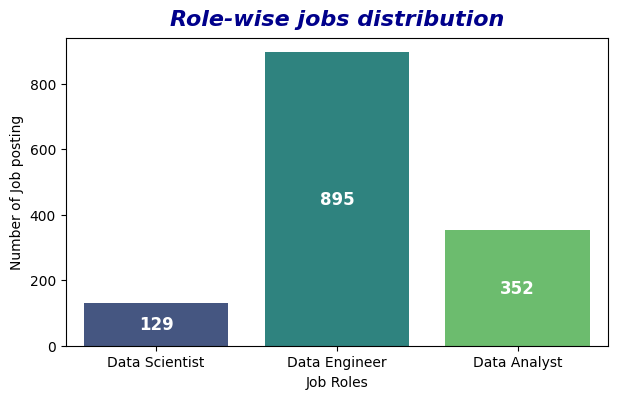


***📊Key Insight :** Data Engineer roles dominate the job market with significantly higher job postings, indicating strong industry demand for professionals who can build, manage, and scale data infrastructure compared to analyst and scientist roles.*

In [99]:
plt.figure(figsize=(7,4))
temp = sns.countplot(data=df, x='normalized_title', hue='normalized_title', palette='viridis')
plt.title('Role-wise jobs distribution',fontsize=16, color='darkblue',fontstyle='italic', pad=9, fontweight='bold')
plt.xlabel('Job Roles', fontsize=10)
plt.ylabel('Number of Job posting', fontsize=10)

for i in temp.containers:
    temp.bar_label(i, label_type='center', fontsize=12, color='white',fontweight='bold')

plt.show()

display(Markdown('\n***📊Key Insight :** Data Engineer roles dominate the job market with significantly higher job postings, indicating strong industry demand for professionals who can build, manage, and scale data infrastructure compared to analyst and scientist roles.*'))

### ⚖️ The "Skill Gap": Compare the top 5 skills for each of these three roles.

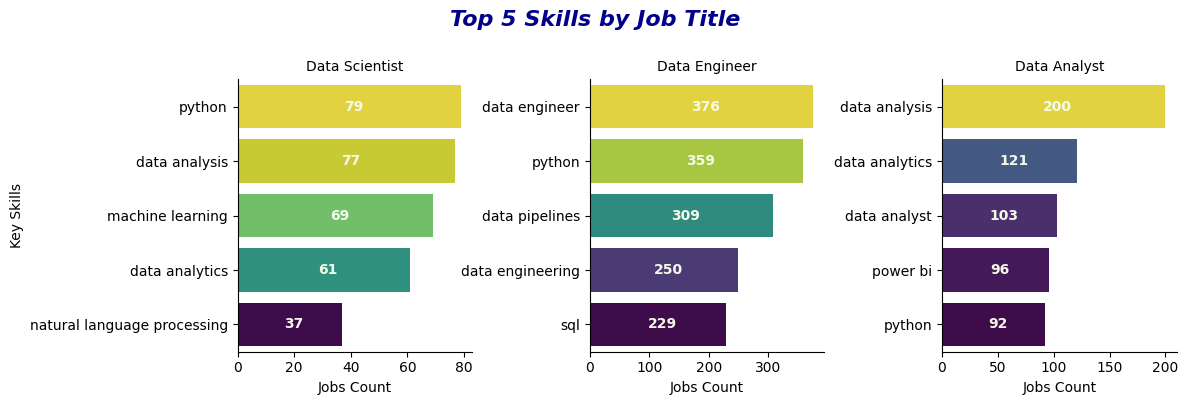

***📊Key Insight :** Python emerges as a core skill across all data roles, while each position emphasizes specialized skills—machine learning for Data Scientists, data pipelines for Data Engineers, and visualization tools for Data Analysts.*

In [110]:
# Explode skills for the whole subset
df_subset = df.copy()
df_subset['key_skills'] = df_subset['key_skills'].str.split(', ')
df_exploded = df_subset.explode('key_skills')

# Use FacetGrid for 3 separate vertical columns
g = sns.FacetGrid(df_exploded, col="normalized_title", col_wrap=3, height=4, aspect=1, sharey=False, sharex=False)

# Map a barplot to each grid
def draw_bar(data, **kwargs): 
    top_5 = data['key_skills'].value_counts().head(5)
    temp = sns.barplot(x=top_5.values, y=top_5.index, hue=top_5.values, palette='viridis')
    # Set bar labels
    for i in temp.containers: 
        temp.bar_label(i, padding=3, fontsize=10, label_type='center', color='#F5FAE8', fontweight='bold')
        
g.map_dataframe(draw_bar)
g.set_titles("{col_name}")
g.set_axis_labels("Jobs Count", "Key Skills")
g.fig.suptitle('Top 5 Skills by Job Title', fontsize=16, color='darkblue', fontstyle='italic', fontweight='bold', y=1)
plt.tight_layout()
plt.subplots_adjust(wspace=0.5) 
plt.show()
print('\n')
display(Markdown('***📊Key Insight :** Python emerges as a core skill across all data roles, while each position emphasizes specialized skills—machine learning for Data Scientists, data pipelines for Data Engineers, and visualization tools for Data Analysts.*'))

### 🎓 Experience Thresholds: Compare avg_exp(year) to see which role is most accessible for freshers.

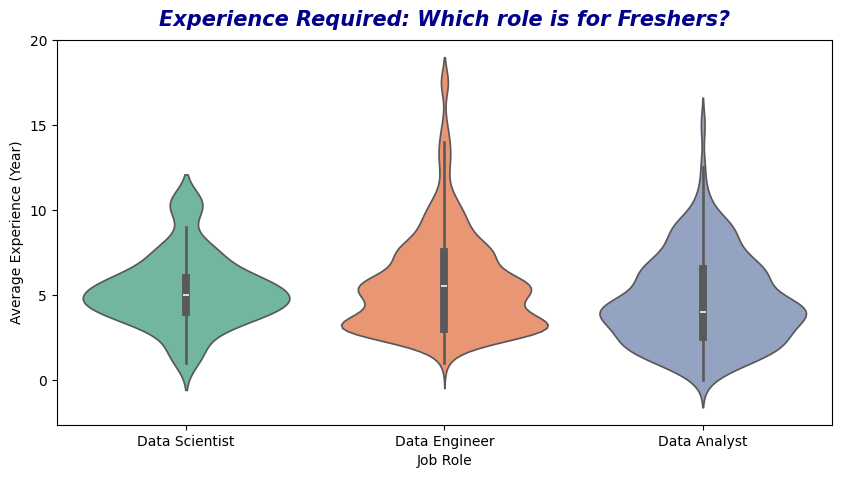

***📊Key Insight :** Data Analyst roles typically require lower average experience, making them more accessible to freshers, whereas Data Scientist and Data Engineer positions generally expect higher experience and stronger technical depth.*

In [105]:
plt.figure(figsize=(10,5))
sns.violinplot(x=df['normalized_title'], y=df['avg_exp(year)'], data=df, hue=df['normalized_title'], palette='Set2',inner='box')
plt.title('Experience Required: Which role is for Freshers?',fontsize=15,color='darkblue',fontstyle='italic', pad=10, fontweight='bold')
plt.xlabel('Job Role')
plt.ylabel('Average Experience (Year)')
plt.show()

display(Markdown('***📊Key Insight :** Data Analyst roles typically require lower average experience, making them more accessible to freshers, whereas Data Scientist and Data Engineer positions generally expect higher experience and stronger technical depth.*'))

## 2️⃣ Geographical & Market Analysis :

### 📍 Top Cities: Bar chart of the most frequent values in location.

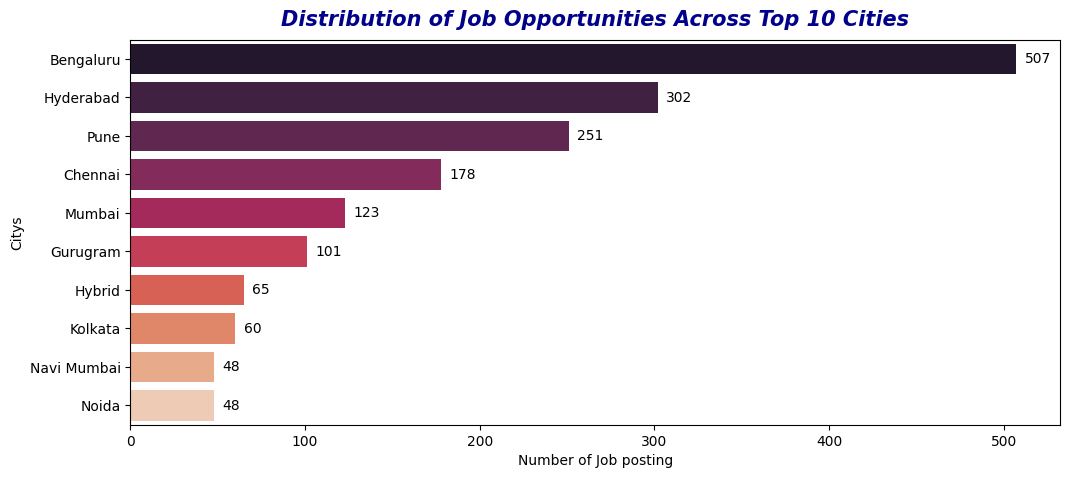

***📊Key Insight :** Bengaluru leads job opportunities by a wide margin, followed by Hyderabad and Pune, highlighting India’s major tech hubs, while tier-2 cities and hybrid roles contribute comparatively fewer openings in the overall job market.*

In [107]:
top10_loc = location_counts.head(10)
plt.figure(figsize=(12,5))
temp = sns.barplot(y=top10_loc.index, x=top10_loc.values, hue=top10_loc.index, palette='rocket')
plt.title('Distribution of Job Opportunities Across Top 10 Cities', fontsize=15, color='darkblue', fontstyle='italic', pad=10, fontweight='bold')
plt.xlabel('Number of Job posting', fontsize=10)
plt.ylabel('Citys',fontsize=10)

for i in temp.containers: 
    temp.bar_label(i, padding=6, fontsize=10)

plt.show()
display(Markdown('***📊Key Insight :** Bengaluru leads job opportunities by a wide margin, followed by Hyderabad and Pune, highlighting India’s major tech hubs, while tier-2 cities and hybrid roles contribute comparatively fewer openings in the overall job market.*'))

### 🏢 Company Presence: Distribution of job openings across different company names.

In [89]:
# show top 5 maximum jobs post company
df['company'].value_counts().head(5).reset_index(name='Jobs count')

,company,Jobs count
0,Accenture,370
1,Wipro,37
2,Virtusa,33
3,IBM,19
4,Diverse Lynx,16


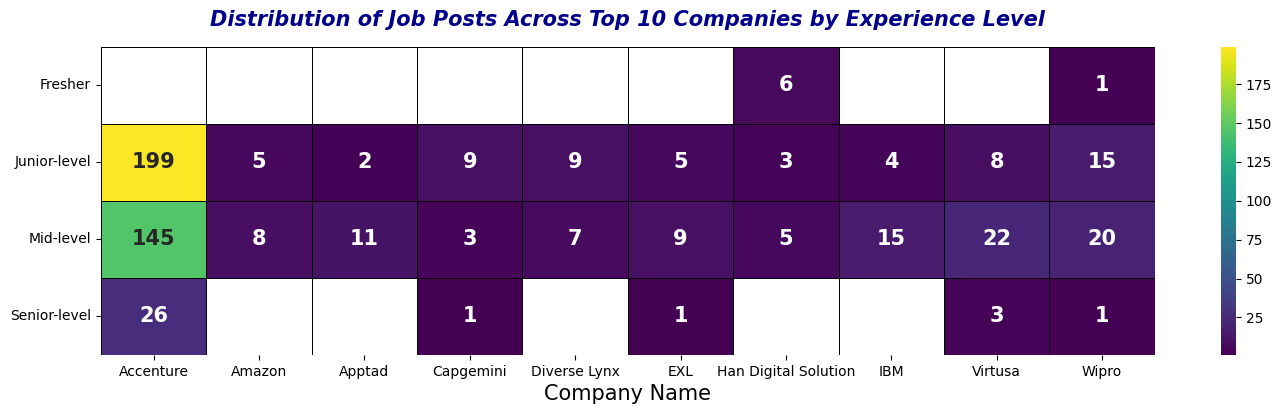

***📊Key Insight :** Most job postings from top companies are concentrated at junior and mid levels, indicating strong demand for early-career professionals, while fresher and senior roles remain limited and selectively hired across organizations.*

In [109]:
# Fatch top10 company name
top_10_company = df['company'].value_counts().head(10).index
# fatch company total jobs post
temp = df[df['company'].isin(top_10_company)].groupby(['company','exp_level']).size().reset_index(name='Jobs count')
# Create pivot table
pivot_table = temp.pivot(index='exp_level', columns='company', values='Jobs count')

plt.figure(figsize=(17,4))
sns.heatmap(pivot_table, annot=True, fmt='.0f', linewidths=0.5, linecolor='black', annot_kws=dict(size=15,weight='bold'), cmap='viridis')
plt.title('Distribution of Job Posts Across Top 10 Companies by Experience Level',fontsize=15, color='darkblue', fontstyle='italic', pad=15, fontweight='bold')
plt.xlabel('Company Name', fontsize=15)
plt.ylabel('')
plt.yticks(fontsize=10, rotation=0)
plt.show()

display(Markdown('***📊Key Insight :** Most job postings from top companies are concentrated at junior and mid levels, indicating strong demand for early-career professionals, while fresher and senior roles remain limited and selectively hired across organizations.*'))

### 🌐 Multiple Locations: Analyze has_multiple_loc to see if companies are moving toward decentralized hiring.

In [40]:
is_multiple_loc = df['has_multiple_loc'].value_counts().reset_index(name='Count')
is_multiple_loc

,has_multiple_loc,Count
0,False,1183
1,True,193


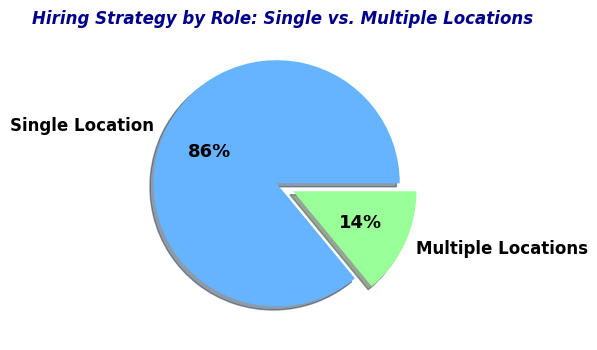

***📊Key Insight :** The majority of job postings are tied to single locations, suggesting companies prefer role-specific city hiring, while a smaller share of multi-location roles reflects limited flexibility in geographic hiring strategies.*

In [111]:
# Set labels
labels = ['Multiple Locations' if x else 'Single Location' for x in is_multiple_loc.index]

plt.figure(figsize=(4,4))
patches, texts, autotext =plt.pie(is_multiple_loc['Count'], labels=labels, autopct='%1.f%%', colors=['#66b3ff','#99ff99'], explode=(0.05, 0.1), shadow=True)
for text in texts: # Labels fontsize
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotext: # Percentage fontsize
    autotext.set_fontsize(13)
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    
plt.title('Hiring Strategy by Role: Single vs. Multiple Locations', fontsize=12, color='darkblue', fontstyle='italic', fontweight='bold')
plt.show()

display(Markdown('***📊Key Insight :** The majority of job postings are tied to single locations, suggesting companies prefer role-specific city hiring, while a smaller share of multi-location roles reflects limited flexibility in geographic hiring strategies.*'))

## 3️⃣ Experience & Seniority Trends :

### 📊 Experience Distribution: Histogram of avg_exp(year) to find the most in-demand experience bracket.

In [42]:
print("Top 5 Experience Years:")
temp = df['avg_exp(year)'].value_counts().head(5).reset_index()
temp.columns = ['Average Experience (Year)','Count']
temp

Top 5 Experience Years:


,Average Experience (Year),Count
0,3.0,235
1,5.5,182
2,7.5,115
3,4.5,111
4,4.0,100


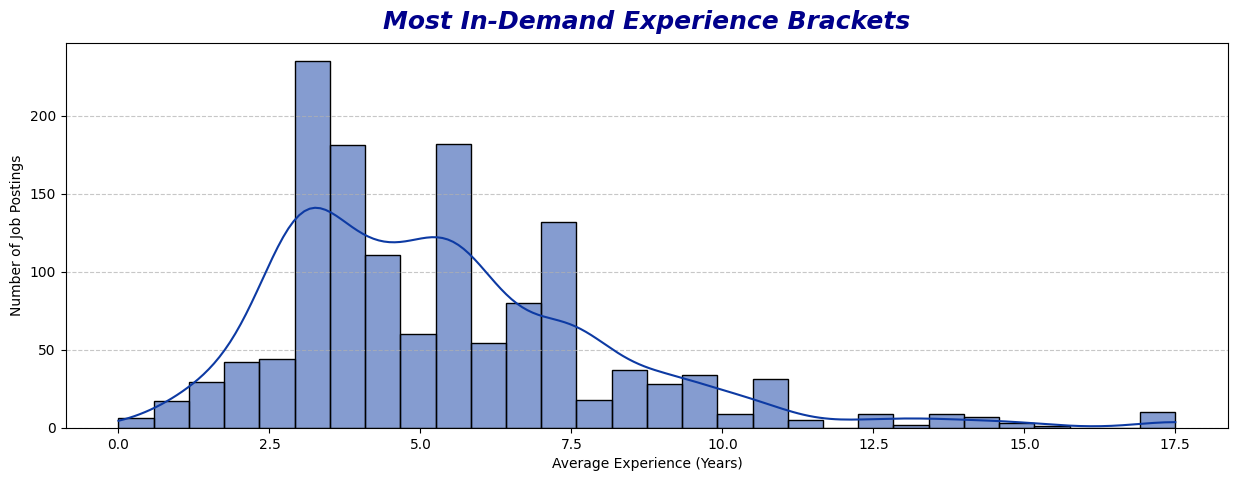

***📊Key Insight :** Job demand peaks between three to six years of experience, showing that companies prioritize candidates with proven industry exposure, while very low and very high experience brackets attract significantly fewer job opportunities.*

In [112]:
plt.figure(figsize=(15,5))
sns.histplot(df['avg_exp(year)'], kde=True, bins=30, color='#0D3AA3', edgecolor='black')
plt.title('Most In-Demand Experience Brackets',fontsize=18, color='darkblue', fontstyle='italic', fontweight='bold', pad=10)
plt.xlabel('Average Experience (Years)')
plt.ylabel('Number of Job Postings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

display(Markdown('***📊Key Insight :** Job demand peaks between three to six years of experience, showing that companies prioritize candidates with proven industry exposure, while very low and very high experience brackets attract significantly fewer job opportunities.*'))

### 🍰 Level Breakdown: Pie chart of exp_level (Entry, Mid, Senior).

In [116]:
temp = df['exp_level'].value_counts().reset_index(name='count')
temp

,exp_level,count
0,Junior-level,631
1,Mid-level,574
2,Fresher,94
3,Senior-level,77


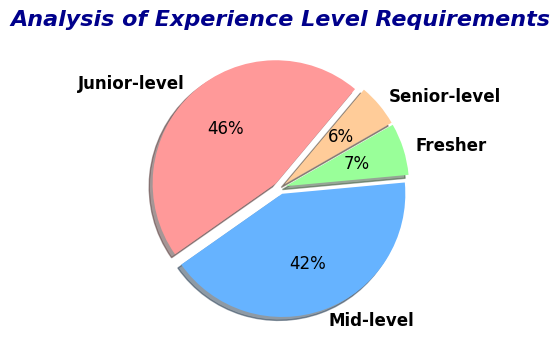

***📊Key Insight :** Junior and mid-level roles dominate overall hiring requirements, indicating companies focus on building scalable teams with moderately experienced professionals rather than investing heavily in fresher or senior-level hiring.*

In [117]:
plt.figure(figsize=(4,4))
patches, texts, autotexts = plt.pie(temp['count'], labels=temp['exp_level'], autopct='%1.f%%', colors=['#ff9999','#66b3ff','#99ff99', '#ffcc99'], 
                            startangle=50, explode=[0.05]*len(temp), shadow=True)
# Increase font size for percentages and labels
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')
    
plt.title('Analysis of Experience Level Requirements',fontsize=16, color='darkblue', fontstyle='italic', fontweight='bold')
plt.show()

display(Markdown('***📊Key Insight :** Junior and mid-level roles dominate overall hiring requirements, indicating companies focus on building scalable teams with moderately experienced professionals rather than investing heavily in fresher or senior-level hiring.*'))

### 🔍 What experience levels are most in demand for each job title?.

In [121]:
temp= df[['normalized_title','exp_level']].value_counts().reset_index(name='count').sort_values(by='normalized_title')
# Create pivot table
pivot_table = temp.pivot(index='normalized_title', columns='exp_level', values='count')
pivot_table

exp_level,Fresher,Junior-level,Mid-level,Senior-level
normalized_title,,,,
Data Analyst,67,153,123,9
Data Engineer,18,414,401,62
Data Scientist,9,64,50,6


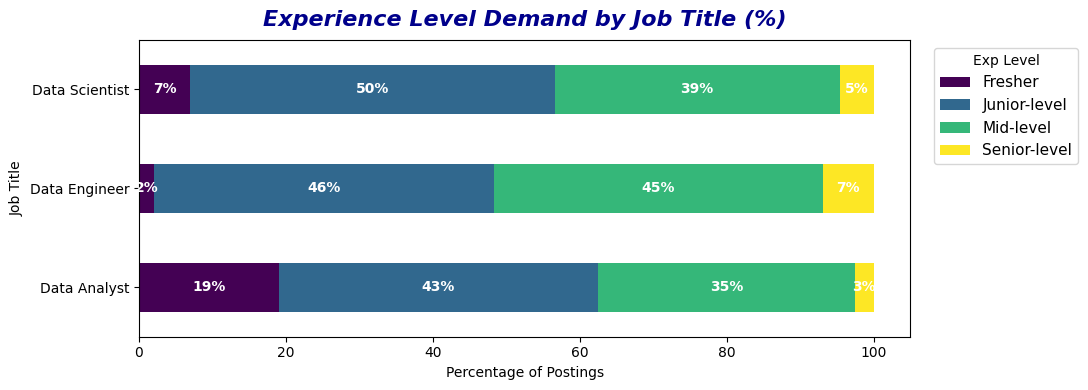

***📊Key Insight :** Data Analyst roles show higher fresher demand compared to Data Scientist and Data Engineer roles, while all positions heavily favor junior and mid-level professionals, reflecting skill maturity requirements across different data roles.*

In [123]:
# Normalize the data to percentage
pivot_perc = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
# Plotting
ax= pivot_perc.plot(kind='barh', stacked=True, figsize=(11,4), colormap='viridis')

for container in ax.containers:
    # labels creates a list of strings
    labels = [f'{v.get_width():.0f}%' if v.get_width() > 0 else '' for v in container]
    # Add the labels to the center of each segment
    ax.bar_label(container, labels=labels, label_type='center', color='#FFFFFF', fontsize=10, fontweight='bold')
    
plt.title('Experience Level Demand by Job Title (%)',fontsize=16, color='darkblue', fontstyle='italic', fontweight='bold', pad=10)
plt.xlabel('Percentage of Postings')
plt.ylabel('Job Title')
plt.legend(title='Exp Level', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()

display(Markdown('***📊Key Insight :** Data Analyst roles show higher fresher demand compared to Data Scientist and Data Engineer roles, while all positions heavily favor junior and mid-level professionals, reflecting skill maturity requirements across different data roles.*'))

## 4️⃣ Skills & Competency Mapping

### ☁️ Skill Frequency: Countplot or WordCloud of the key_skills column.

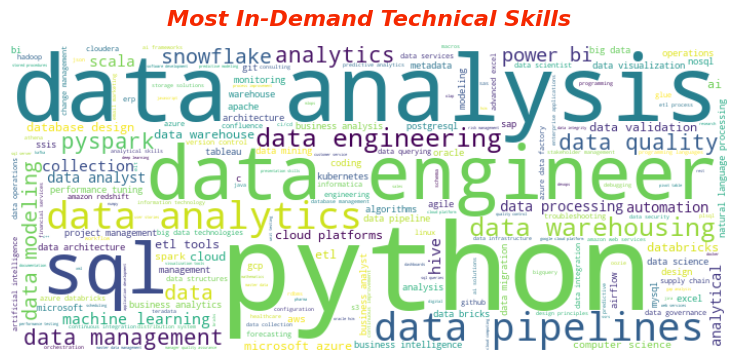

***📊Key Insight :** Data analysis and Python dominate skill demand, followed by data engineering, SQL, and data pipelines, indicating that employers prioritize strong programming, analytical thinking, and data infrastructure skills across most data-related roles.*

In [130]:
wordcloud = WordCloud(
    width=700,
    height=300,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(key_skill_counts)

plt.figure(figsize=(12, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most In-Demand Technical Skills',fontsize=16, color='#F52800', fontstyle='italic', fontweight='bold', pad=13)
plt.show()

display(Markdown('***📊Key Insight :** Data analysis and Python dominate skill demand, followed by data engineering, SQL, and data pipelines, indicating that employers prioritize strong programming, analytical thinking, and data infrastructure skills across most data-related roles.*'))

## 5️⃣ Recruitment Velocity (Temporal Analysis)

### 🆕How 'fresh' is the current job market, and which specific roles are driving recent hiring activity?

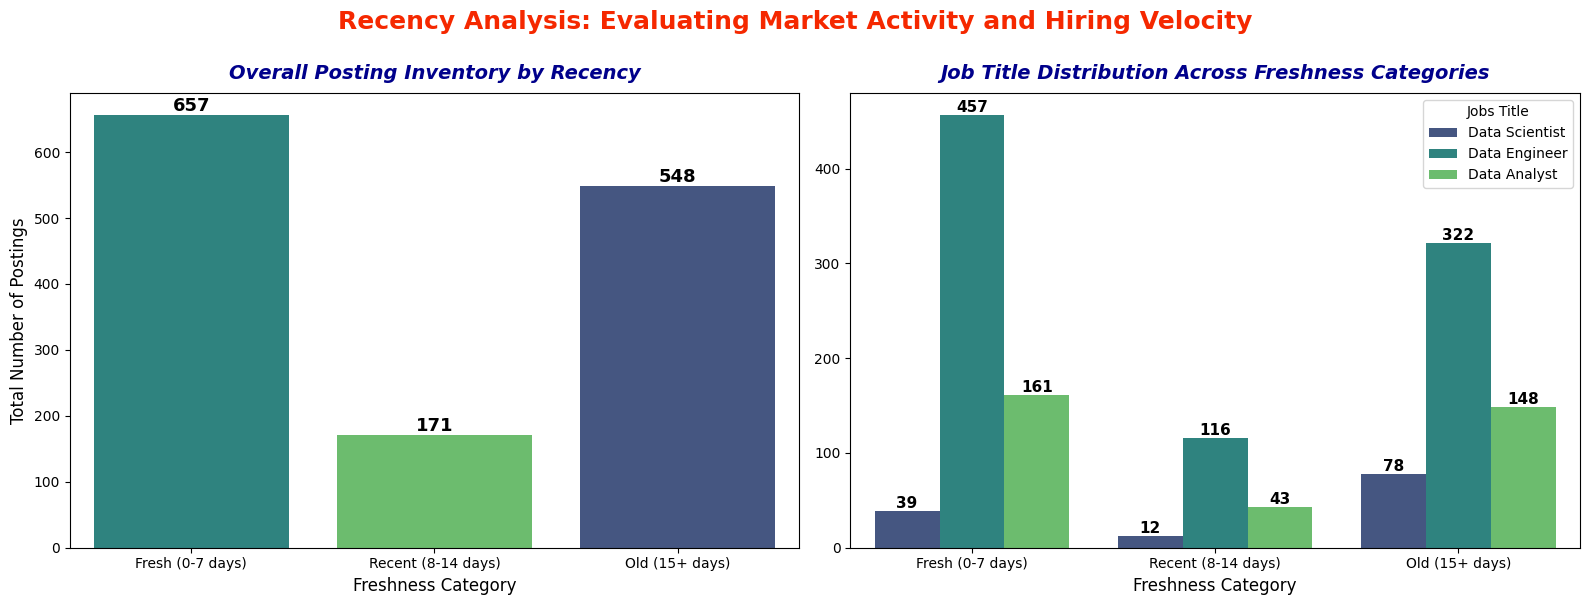

***📊Key Insight :** A large proportion of job postings fall under fresh and old categories, suggesting continuous hiring activity but also slower closure for certain roles, indicating competitive markets and varying hiring speeds across job titles.*

In [131]:
plt.figure(figsize=(16,6))
freshness_orders = ['Fresh (0-7 days)','Recent (8-14 days)','Old (15+ days)']
# --- Subplot 1: Overall Market Freshness ---
ax1 = plt.subplot(1,2,1)
sns.countplot(x=df['post_freshness'], hue=df['post_freshness'], palette='viridis', order=freshness_orders)
plt.title("Overall Posting Inventory by Recency", fontsize=14, color='darkblue', fontstyle='italic', pad=10, fontweight='bold')
plt.xlabel("Freshness Category", fontsize=12)
plt.ylabel("Total Number of Postings", fontsize=12)
for i in ax1.containers: 
    ax1.bar_label(i, fontsize=13, color='black',fontweight='bold')
    
# --- Subplot 2: Role-Specific Freshness ---
ax2 = plt.subplot(1,2,2)
sns.countplot(x=df['post_freshness'], hue=df['normalized_title'], palette='viridis', order=freshness_orders)
plt.title("Job Title Distribution Across Freshness Categories", fontsize=14, color='darkblue', fontstyle='italic', pad=10, fontweight='bold')
plt.xlabel("Freshness Category", fontsize=12)
plt.ylabel("")
plt.legend(title="Jobs Title", loc='upper right')
for j in ax2.containers: 
    ax2.bar_label(j, fontsize=11, color='black', fontweight='bold') 
    
plt.suptitle("Recency Analysis: Evaluating Market Activity and Hiring Velocity", fontsize=18, fontweight='bold', y=1.0, color='#F52800')
plt.tight_layout()
plt.show()

display(Markdown('***📊Key Insight :** A large proportion of job postings fall under fresh and old categories, suggesting continuous hiring activity but also slower closure for certain roles, indicating competitive markets and varying hiring speeds across job titles.*'))

### ⏳ Hiring Urgency: Use days_since_posted to calculate the average time a job remains active.

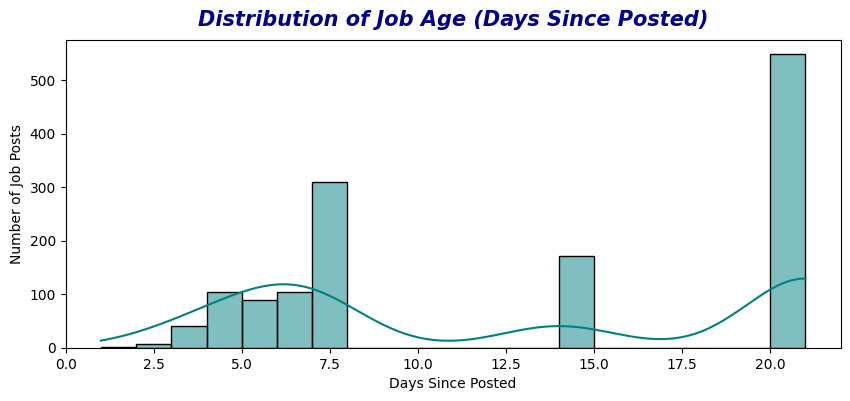

***📊Key Insight :** Most job postings cluster between five and eight days, with another spike beyond fifteen days, showing that while many roles attract quick attention, a notable portion remains open longer due to skill or experience mismatches.*

In [132]:
plt.figure(figsize=(10, 4))
sns.histplot(df['days_since_posted'], bins=20, kde=True, color='teal')
plt.title('Distribution of Job Age (Days Since Posted)',fontsize=15, color='darkblue', fontstyle='italic', fontweight='bold', pad=10)
plt.xlabel('Days Since Posted')
plt.ylabel('Number of Job Posts')
plt.show()

display(Markdown('***📊Key Insight :** Most job postings cluster between five and eight days, with another spike beyond fifteen days, showing that while many roles attract quick attention, a notable portion remains open longer due to skill or experience mismatches.*'))

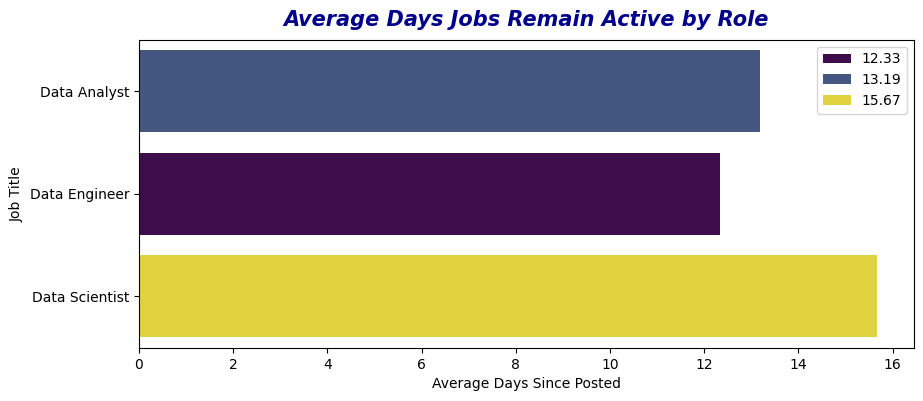

***📊Key Insight :** Data Scientist positions remain active the longest, followed by Data Analyst and Data Engineer roles, suggesting that higher skill complexity and niche requirements may slow hiring timelines compared to more operational data roles.*

In [133]:
# Find average day for all job title
avg_day = df.groupby('normalized_title')['days_since_posted'].mean().round(2)

plt.figure(figsize=(10,4))
sns.barplot(x=avg_day.values, y=avg_day.index, hue =avg_day.values, palette='viridis')
plt.title('Average Days Jobs Remain Active by Role',fontsize=15, color='darkblue', fontstyle='italic', fontweight='bold', pad=10)
plt.ylabel('Job Title', fontsize=10)
plt.xlabel('Average Days Since Posted', fontsize=10)
plt.show()

display(Markdown('***📊Key Insight :** Data Scientist positions remain active the longest, followed by Data Analyst and Data Engineer roles, suggesting that higher skill complexity and niche requirements may slow hiring timelines compared to more operational data roles.*'))

## 6️⃣ Company Quality & Rating Analysis

### 🌟 Rating Distribution: A distribution plot of company rating.

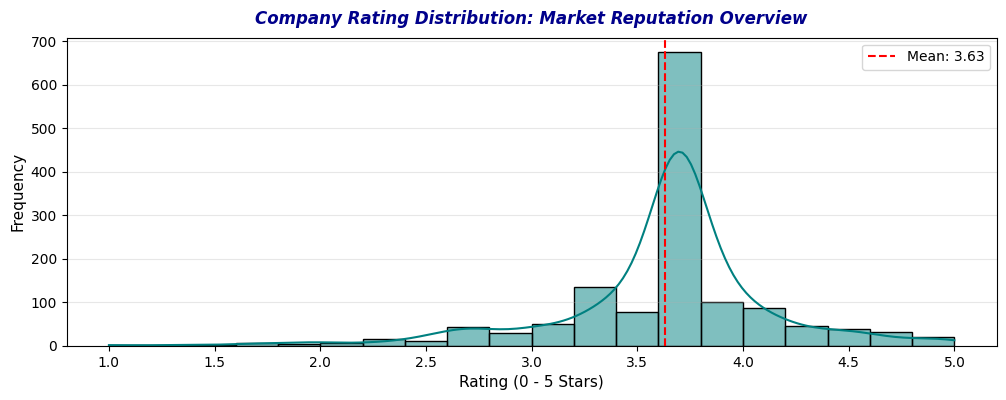

***📊Key Insight :** Most companies cluster around mid-to-high ratings near the average, indicating generally positive employer reputation, while fewer low-rated companies appear in the dataset, suggesting job seekers prefer applying to better-rated organizations.*

In [134]:
plt.figure(figsize=(12,4))
rating_companies = df[df['rating'] > 0]
# Creating the distribution plot
sns.histplot(rating_companies['rating'], kde=True, color='teal', bins=20, edgecolor='black')
# Adding a vertical line for the Average Rating
plt.axvline(rating_companies['rating'].mean(), color='red', linestyle='--', label=f'Mean: {rating_companies['rating'].mean():.2f}')
plt.title('Company Rating Distribution: Market Reputation Overview',color='darkblue', fontstyle='italic', pad=10, fontweight='bold')
plt.xlabel('Rating (0 - 5 Stars)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

display(Markdown('***📊Key Insight :** Most companies cluster around mid-to-high ratings near the average, indicating generally positive employer reputation, while fewer low-rated companies appear in the dataset, suggesting job seekers prefer applying to better-rated organizations.*'))

### 🏆 Top-Rated Employers: List of companies with a high rating and high hiring volume.

In [51]:
# Group by Company and calculate the count of jobs and average rating
df_company = df.groupby('company').agg(
    jobs_count=('company','count'), # 'count' (volume)
    avg_rating =('rating','mean')  # 'mean' (average rating)
).reset_index()

# Filter out the job_post > 5 companies
df_filtered = df_company[df_company['jobs_count'] > 5]

# Sort values
df_filtered = df_filtered.sort_values(by=['jobs_count','avg_rating'], ascending=False)
df_filtered.head(5)

,company,jobs_count,avg_rating
6,Accenture,370,3.7
550,Wipro,37,3.6
540,Virtusa,33,3.7
248,IBM,19,3.9
148,Diverse Lynx,16,3.5


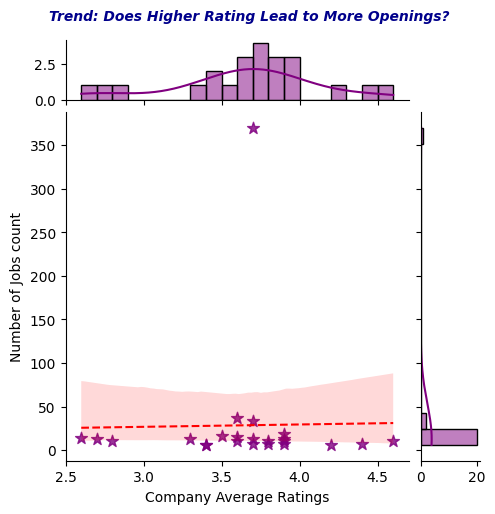

***📊Key Insight :** Higher company ratings do not strongly correlate with a greater number of job openings, indicating that hiring volume is driven more by business needs and scale rather than employer reputation alone.*

In [139]:
sns.jointplot(data=df_filtered, x='avg_rating', y='jobs_count', kind='reg', height=5, marginal_ticks=True,
    joint_kws= dict(marker='*', 
                    scatter_kws=dict(s=80, color='purple')),
    line_kws= dict(color='red', linewidth = 1.5, linestyle='--'),
    marginal_kws= dict(bins=20, fill=True, kde=True, color='purple'),
)
plt.suptitle("Trend: Does Higher Rating Lead to More Openings?",y=1.02, fontsize=10, color='darkblue', fontstyle='italic', fontweight='bold')
plt.xlabel('Company Average Ratings')
plt.ylabel('Number of Jobs count')
plt.show()

display(Markdown('***📊Key Insight :** Higher company ratings do not strongly correlate with a greater number of job openings, indicating that hiring volume is driven more by business needs and scale rather than employer reputation alone.*'))

# 🎯 Project Conclusion
#### This project successfully developed an automated end-to-end pipeline to analyze the Indian job market for data-centric roles. By utilizing Selenium to scrape over 1,500 listings from Naukri.com, the data was cleaned and standardized through rigorous preprocessing, including experience level classification and location normalization.

#### Exploratory Data Analysis revealed that Data Engineering is the most in-demand role, with Bengaluru serving as the primary geographical hub. Essential skills like Python, SQL, and Data Pipelines were identified as critical for candidates. Furthermore, the study concluded that higher company ratings do not strongly correlate with job volume, as hiring is predominantly driven by business scale and immediate operational needs.